In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# Preparación y visualización de los DataFrames

Importo la base de datos del ministerio de educación y renombro las columnas de latitud y longitud

In [149]:
df_colegios_completo = pd.read_excel('D:/BDs_DM/Bd_completa_colegios.xlsx', sheet_name='PADRON_CON_CLAVE', dtype={'CODLOCAL': str})

# Renombra las columnas 'NLAT_IE' y 'NLONG_IE'
df_colegios_completo = df_colegios_completo.rename(columns={"NLAT_IE": "latitude", "NLONG_IE": "longitude"})


## Preprocesamiento del dataframe

Nos quedamos solo con los colegios activos, de modalidad Escolarizada y que no sea instituto ni nido ni un colegio para chicos con alguna discapacidad, ya que el reubicar estos colegios es mas complicado

In [150]:
# Filtra y procesa los datos según tus condiciones
df_colegios_completo_listo = df_colegios_completo[
    (df_colegios_completo['D_ESTADO'] == 'Activa') &
    (df_colegios_completo['D_FORMA'] == 'Escolarizada') &
    (~df_colegios_completo['D_NIV_MOD'].str.contains('Especial|Instituto|Técnico|Escuela')&
     (df_colegios_completo['TALUMNO'] > 0)) 
]


Nos dimos cuenta de lo siguiente de que habian varios colegios con la misma latitud y longitud por lo que decidimos agruparlos y quedarnos solo con un punto en ves de varios para que el modelon no interprete que hay 3 colegios diferentes en el mismo punto.
Para hacer esto hicimos lo siguiente:
1. Agrupamos por latitud y longitud a todos los colegios
2. Unimos los D_NIV_MOD que sean diferentes usando el conector '&' (antes de concatenar ordenamos)
3. Sumamos el total de alumnos y el total de docentes en cada grupi
4. Eliminamos los duplicados por latitud y longitud y nos quedamos con el primero (en el que juntamos el D_NIV_MOD y sumamos la cantidad de alumnos y de docentes
5. Eliminamos las columnas de la cantidad de alumnos hombres y mujeres, ya que son datos los cuales no vamos a utilizar

In [151]:
# Agrupa por 'latitude' y 'longitude'
agrupado = df_colegios_completo_listo.groupby(['latitude', 'longitude'])

# Define una función personalizada para realizar las operaciones deseadas dentro de cada grupo
def custom_agg(group):
    # Reemplaza "Inicial - Jardín" por "Inicial"
    group['D_NIV_MOD'] = group['D_NIV_MOD'].str.replace('.*Inicial.*', 'Inicial', regex=True)
    
    # Concatena y ordena alfabéticamente los valores de 'D_NIV_MOD' si son diferentes en el grupo
    unique_values = group['D_NIV_MOD'].unique()
    if len(unique_values) > 1:
        group['D_NIV_MOD'] = ' & '.join(sorted(unique_values))
    
    # Suma 'TALUMNO' y 'TDOCENTE'
    group['TALUMNO'] = group['TALUMNO'].sum()
    group['TDOCENTE'] = group['TDOCENTE'].sum()
    group['TSECCION'] = group['TSECCION'].sum()
    
    # Elimina las filas duplicadas
    group = group.drop_duplicates(subset=['latitude', 'longitude'])
    
    return group

# Aplica la función personalizada al grupo y obtén el resultado
result_df = agrupado.apply(custom_agg).reset_index(drop=True)
result_df = result_df.drop(["TALUM_MUJ", "TALUM_HOM"], axis=1)

# Chequeo de que todo haya salido bien
print("Valores de 'D_NIV_MOD' antes de la agrupación:")
print(df_colegios_completo_listo['D_NIV_MOD'].unique())

print("\nValores de 'D_NIV_MOD' después de la agrupación:")
print(result_df['D_NIV_MOD'].unique())

Valores de 'D_NIV_MOD' antes de la agrupación:
['Inicial - Jardín' 'Primaria' 'Secundaria' 'Inicial - Cuna-jardín'
 'Inicial - Cuna']

Valores de 'D_NIV_MOD' después de la agrupación:
['Inicial & Primaria' 'Primaria & Secundaria' 'Inicial' 'Primaria'
 'Inicial & Primaria & Secundaria' 'Secundaria' 'Inicial & Secundaria']


Eliminamos las columnas con la data encriptada y tambien las columnas que no vamos a utilizar:

In [152]:
columnas_a_eliminar = ['Clave', 'COD_MOD', 'ANEXO', 'NIV_MOD', 'D_FORMA', 'COD_CAR', 'TIPSSEXO', 'GESTION',
                       'GES_DEP', 'DIRECTOR', 'TELEFONO', 'EMAIL', 'PAGWEB', 'DIR_CEN', 'REFERENCIA',
                       'LOCALIDAD', 'CODCP_INEI', 'CODCCPP', 'CEN_POB', 'AREA_CENSO', 'CODGEO', 'CODOOII',
                       'D_DREUGEL', 'TIPOPROG', 'D_TIPOPROG', 'COD_TUR', 'ESTADO', 'D_ESTADO', 'D_FTE_DATO',
                       'FECHAREG', 'FECHA_ACT']

# Eliminar las columnas del DataFrame
result_df = result_df.drop(columnas_a_eliminar, axis=1)

## Guardar los resultados en un dataset

Guardamos el dataframe resultante como excel para luego importarlo y solo trabajar con este sin necesidad de usar el anterior.

In [153]:
result_df.to_excel('resultados_colegios.xlsx', index=False)

Importo el dataframe de colegios del MINEDU listo para usar.

In [83]:
df_Minedu=pd.read_excel('D:/BDs_DM/resultados_colegios.xlsx')

## Exploración del dataset preprocesado

Grafico de departamentos con mas colegios estatales

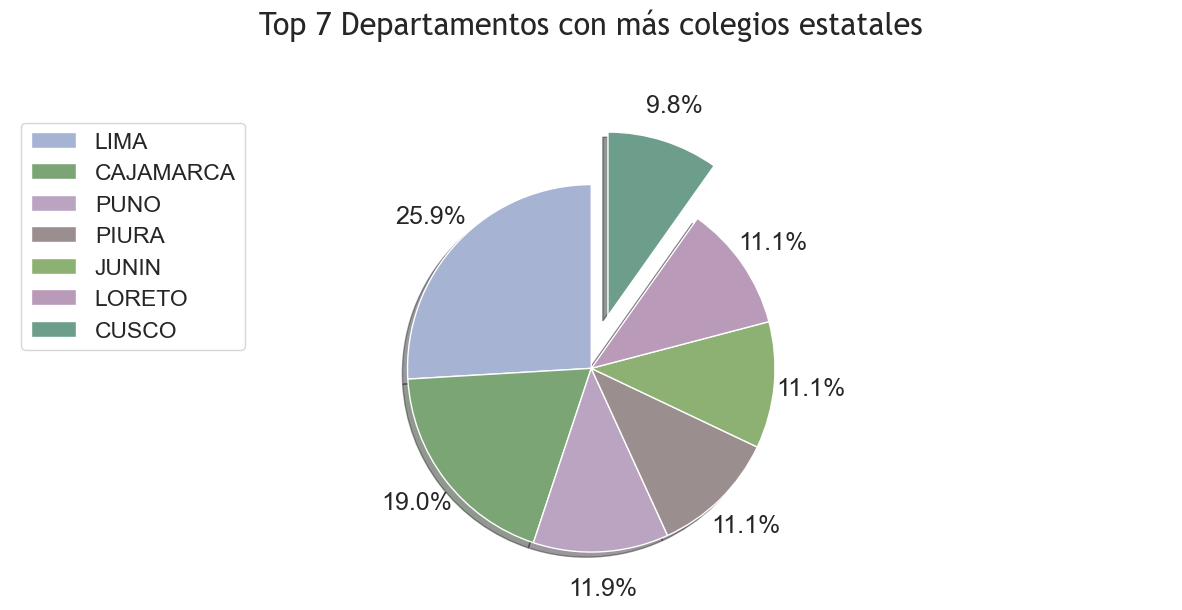

In [84]:
df_graf1 = df_Minedu.groupby('D_DPTO').size().sort_values(ascending=False)
df_graf1 = df_graf1.head(7)
explode_list = [0, 0, 0, 0, 0, 0, 0.3]
colors = ["#A7B3D3", "#7CA576", "#BBA4C1", "#9B8E8E", "#8DB172", "#B99AB9", "#6c9e8b"]  # Colores más claros
sns.set(font_scale=1.5)  # Aumentar el tamaño de letra
sns.set_style("whitegrid")  # Cambiar el estilo

plt.figure(figsize=(15, 6))
plt.pie(df_graf1, labels=None, autopct='%1.1f%%', startangle=90, shadow=True, pctdistance=1.2, explode=explode_list, colors=colors)

plt.title('Top 7 Departamentos con más colegios estatales', pad=55, fontname="Trebuchet MS", fontsize=22)  # Cambiar el tipo de letra y tamaño
plt.axis('equal')
plt.legend(labels=df_graf1.index, loc='upper left')
plt.show()

Grafico de tipos de colegios mas populares

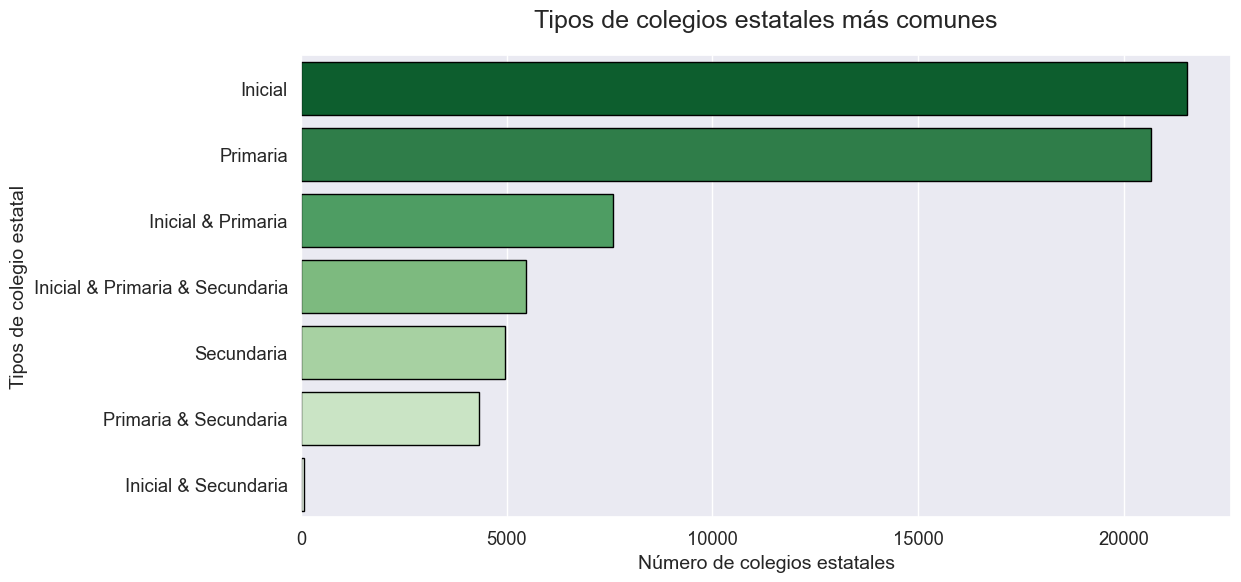

In [85]:
df_graf2 = df_Minedu.groupby('D_NIV_MOD').size().sort_values(ascending=False)
df_graf2 = df_graf2.head(7)
colores = sns.color_palette("Greens", n_colors=len(df_graf2))[::-1]  # Invertir la paleta de colores
sns.set_style("whitegrid")
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=df_graf2, y=df_graf2.index, palette=colores, orient='horizontal', edgecolor='black')
plt.title('Tipos de colegios estatales más comunes', pad=20, fontsize=18)
plt.xlabel('Número de colegios estatales', fontsize=14)
plt.ylabel('Tipos de colegio estatal', fontsize=14)
plt.show()

Grafico de la distribución de los colegios a analizar en todo el Perú

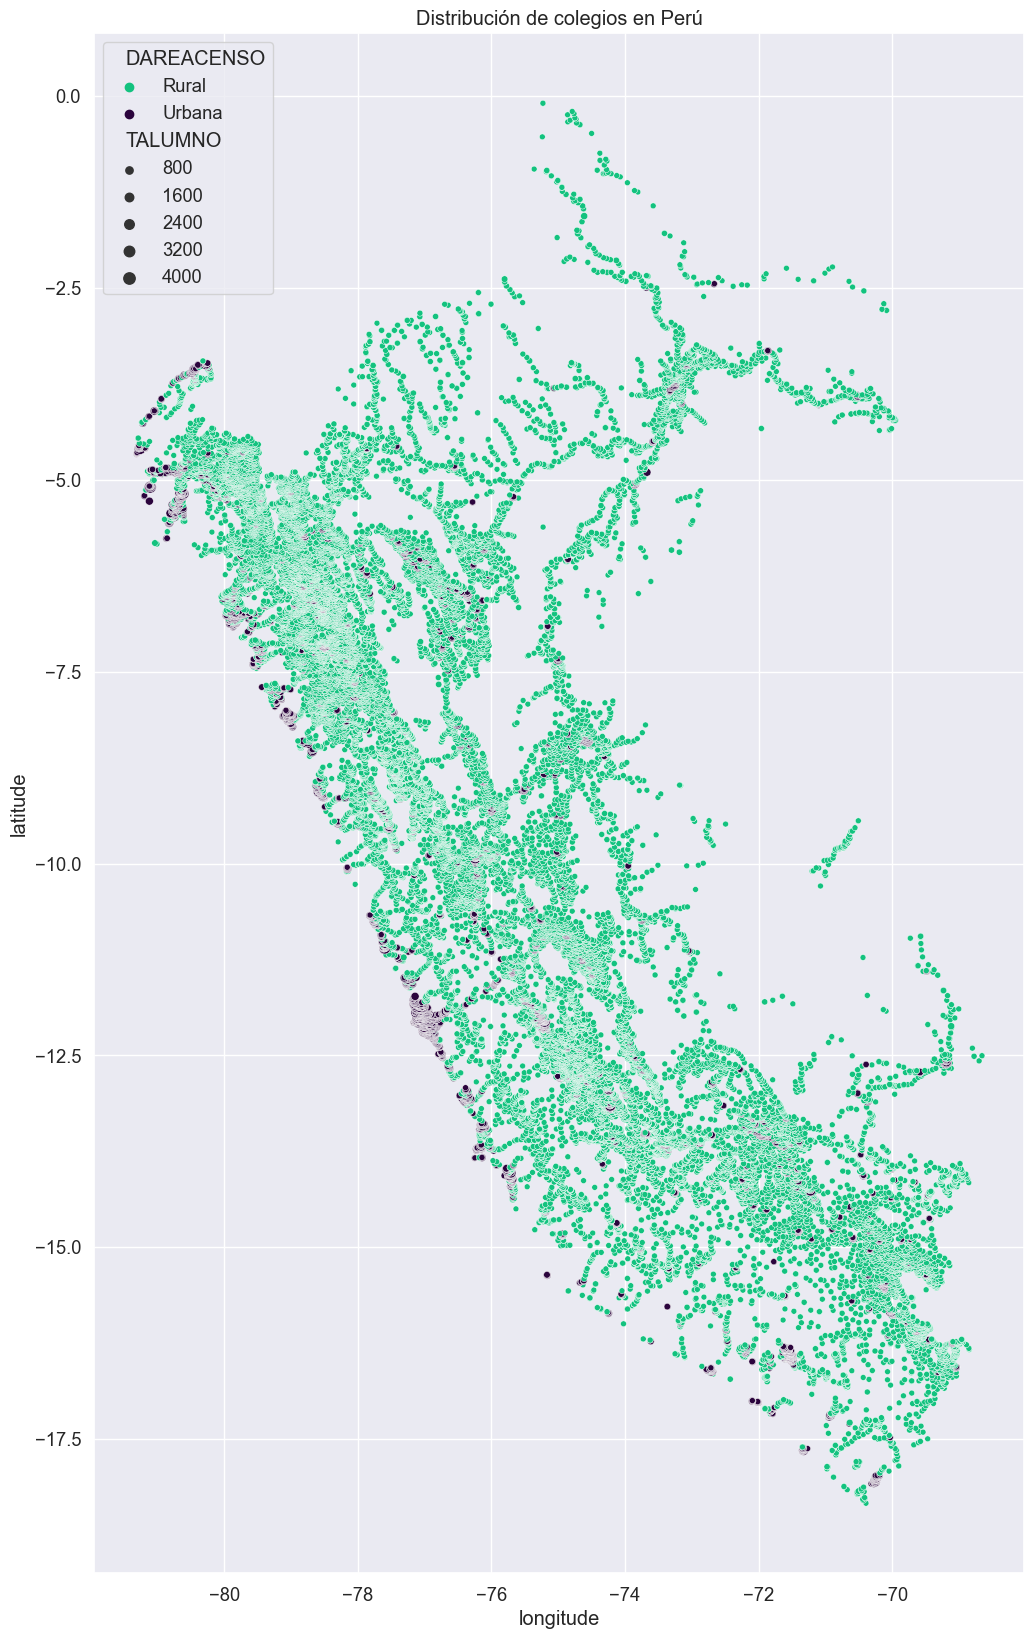

In [86]:
custom_palette = ["#13c27f", "#2b043d"]
plt.figure(figsize=(12, 20))
sns.scatterplot(data=df_Minedu, x='longitude', y='latitude', size='TALUMNO', hue='DAREACENSO', palette=custom_palette)
plt.title("Distribución de colegios en Perú")
plt.show()

Grafico para la distribución por tipo de gestión según el area de censo. Este grafico es relevante, ya que nos muestra que el ratio de cantidad de alumnos por profesor solo es consistente para los colegios publicos de gestion privada mientras que en los otros 2 casos te puedes encontrar colegios de hasta 70 alumnos por profesor y menos de 10 alumnos por profesor

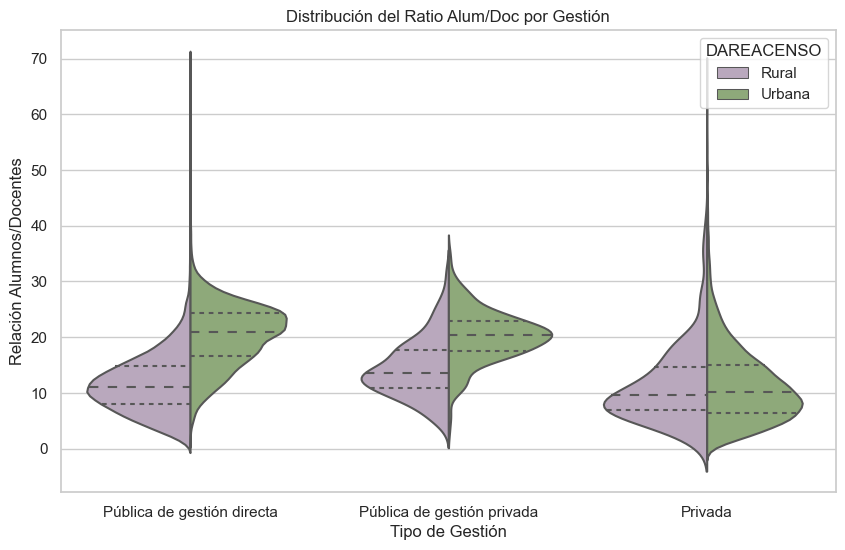

In [87]:
df_violin=df_Minedu.copy()
df_violin['Ratio_alum_doc']=df_violin['TALUMNO']/df_violin['TDOCENTE']

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.violinplot(data=df_violin, x='D_GESTION', y='Ratio_alum_doc', inner='quartile', hue='DAREACENSO', split=True, palette=['#BBA4C1', '#8DB172'])

plt.xlabel('Tipo de Gestión')
plt.ylabel('Relación Alumnos/Docentes')
plt.title('Distribución del Ratio Alum/Doc por Gestión')

plt.show()

In [88]:
df_ratio = df_Minedu[["D_DPTO","TALUMNO","TDOCENTE"]].copy()
df_ratio = df_ratio.groupby("D_DPTO").sum()
df_ratio["Ratio_alum_doc"] = df_ratio["TALUMNO"]/df_ratio["TDOCENTE"]
df_ratio = df_ratio.loc[:,"Ratio_alum_doc"]
df_ratio=pd.DataFrame(df_ratio)
df_ratio.reset_index(inplace=True)

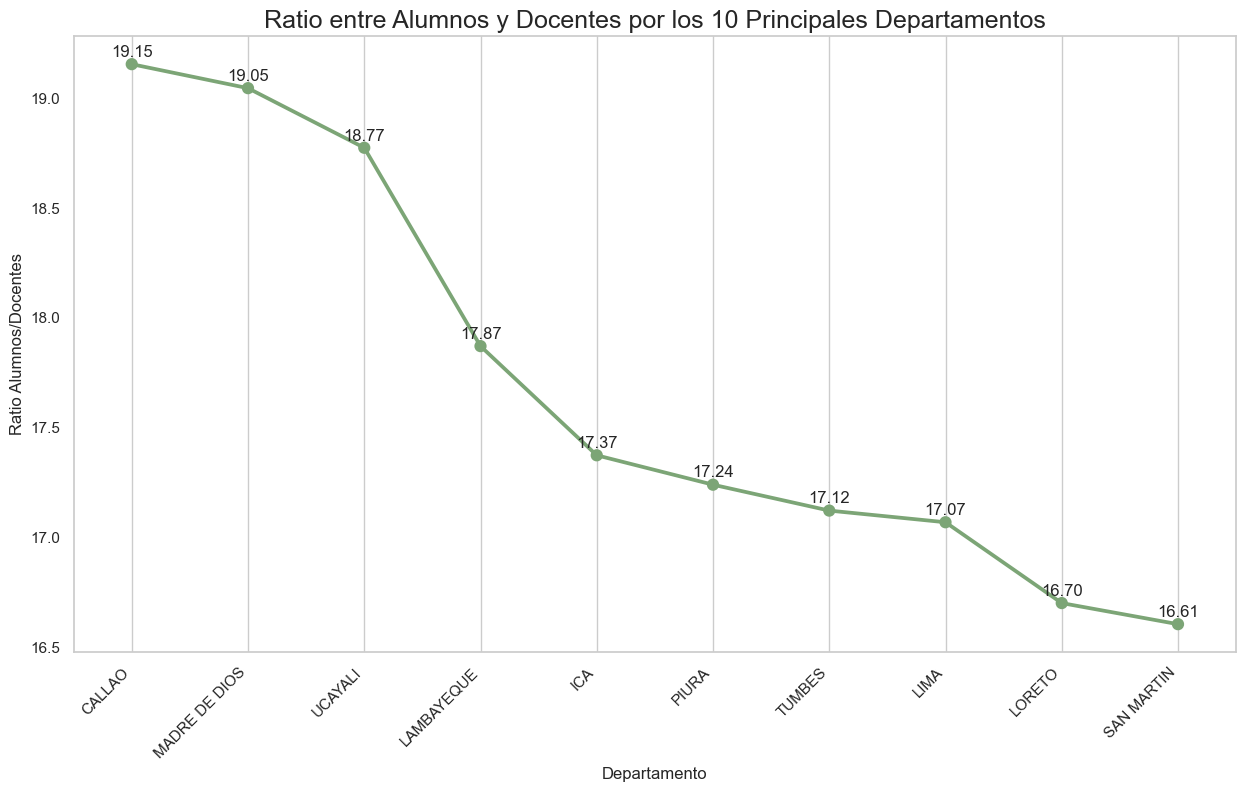

In [89]:
plt.figure(figsize=(15, 8))

df_ratio = df_ratio.sort_values(by="Ratio_alum_doc", ascending=False).head(10)

ax = sns.pointplot(data=df_ratio, x="D_DPTO", y="Ratio_alum_doc", color='#7CA576')

plt.xlabel("Departamento")
plt.ylabel("Ratio Alumnos/Docentes")

ax.set_xticklabels(df_ratio["D_DPTO"], rotation=45, ha='right')

for i, (index, row) in enumerate(df_ratio.iterrows()):
    label = f"{row['Ratio_alum_doc']:.2f}"
    ax.text(i, row['Ratio_alum_doc'] + 0.02, label, ha='center', va='bottom')

plt.title("Ratio entre Alumnos y Docentes por los 10 Principales Departamentos", fontsize=18)

plt.grid()

plt.show()

Grafico de distribución de cantidad de colegios rurales por departamento

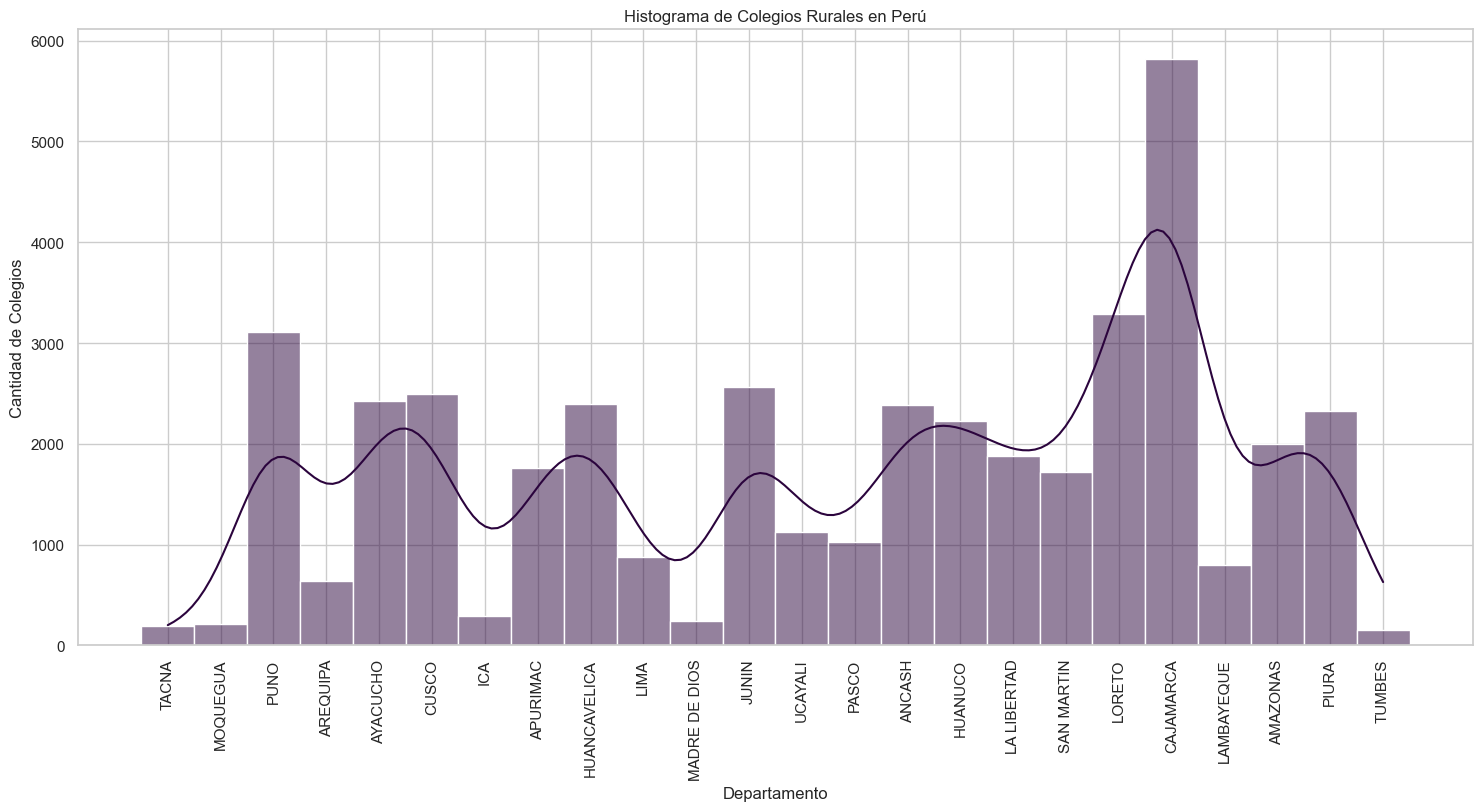

In [160]:
plt.figure(figsize=(18, 8))
sns.histplot(df_Minedu[df_Minedu.DAREACENSO=='Rural'].D_DPTO, kde=True, color="#2b043d")  # Use the color parameter to set the color
plt.xlabel('Departamento')   # Add labels if needed
plt.ylabel('Cantidad de Colegios')
plt.title('Histograma de Colegios Rurales en Perú')

# Rotate x-axis labels vertically
plt.xticks(rotation=90)

plt.show()

## Nuevo dataset del minedu

Este dataset es una el dataset del MINEDY, pero solo con las columnas de NLAT_IE (latitud) y NLONG_IE (longitud), esto se hizo para ahorrar tiempo y no tener que correr el codigo de arriba para poder trabajar mas adelate. 
Tambien se podra haber hecho una copia profunda del df_Minedu y filtrar columnas para solo quedarte con la latitud y longiutd.
A esta base de datos de colegios se le agrega una columna de confidence a la cual le asignamos un valor nulo que trataremos mas adelante, asimismo, se le agrega una etiqueta para poder identificar si se trata de coordenadas de colegio o de edifico (mas adelante a los edificos se les agregará su etiqueta tambien)

In [90]:
df_ubi_colegios = pd.read_excel('D:/BDs_DM/Bd_Ubi_Colegios.xlsx', sheet_name='PADRON_CON_CLAVE')
df_ubi_colegios = df_ubi_colegios.rename(columns={"NLAT_IE": "latitude", "NLONG_IE": "longitude"})
df_colegios_cruzar = df_ubi_colegios[["latitude", "longitude"]].copy()
df_colegios_cruzar["confidence"] = np.nan
df_colegios_cruzar["Etiqueta"] = 1

In [91]:
df_colegios_cruzar = df_colegios_cruzar.loc[df_Minedu.index]
df_colegios_cruzar.shape

(64596, 4)

## Importacion y procesamiento de los datasets de open buildings

Importo la base de datos de colegios del ministerio de educacion, pero esta vez solo con la latitud y la longitud como columnas. Tambien le agrego una columna de confidence a la cual le asignamos un valor nulo que trataremos mas adelante, asimismo, le agrego una etiqueta para poder identificar si se trata de coordenadas de colegio o de edifico (mas adelante a los edificos se les agregará su etiqueta tambien)

Importo todos los archivos de open buildings que cubren el area total de Peru y les agrego la columna etiqueta para saber que se trata de edifcios identificados por estos dataset (edificios)

In [92]:
df_Peru_Web=pd.read_csv('D:/BDs_DM/911_buildings.csv')
df_Peru_Web=df_Peru_Web[["latitude","longitude","confidence"]]
df_Peru_Web["Etiqueta"] = 2
df_Peru_Web.shape

(1048575, 4)

In [93]:
df_Peru1_Web=pd.read_csv('D:/BDs_DM/91b_buildings.csv')
df_Peru1_Web=df_Peru1_Web[["latitude","longitude","confidence"]]
df_Peru1_Web["Etiqueta"] = 2
df_Peru1_Web.shape

(4998969, 4)

In [94]:
df_Peru2_Web=pd.read_csv('D:/BDs_DM/917_buildings.csv')
df_Peru2_Web=df_Peru2_Web[["latitude","longitude","confidence"]]
df_Peru2_Web["Etiqueta"] = 2
df_Peru2_Web.shape

(3547449, 4)

In [95]:
df_Peru3_Web=pd.read_csv('D:/BDs_DM/919_buildings.csv')
df_Peru3_Web=df_Peru3_Web[["latitude","longitude","confidence"]]
df_Peru3_Web["Etiqueta"] = 2
df_Peru3_Web.shape

(301643, 4)

In [96]:
df_Peru4_Web=pd.read_csv('D:/BDs_DM/91d_buildings.csv')
df_Peru4_Web=df_Peru3_Web[["latitude","longitude","confidence"]]
df_Peru4_Web["Etiqueta"] = 2
df_Peru4_Web.shape

(301643, 4)

In [97]:
df_Peru5_Web=pd.read_csv('D:/BDs_DM/91f_buildings.csv')
df_Peru5_Web=df_Peru3_Web[["latitude","longitude","confidence"]]
df_Peru5_Web["Etiqueta"] = 2
df_Peru5_Web.shape

(301643, 4)

In [98]:
df_Peru6_Web=pd.read_csv('D:/BDs_DM/93d_buildings.csv')
df_Peru6_Web=df_Peru3_Web[["latitude","longitude","confidence"]]
df_Peru6_Web["Etiqueta"] = 2
df_Peru6_Web.shape

(301643, 4)

In [99]:
df_Peru7_Web=pd.read_csv('D:/BDs_DM/903_buildings.csv')
df_Peru7_Web=df_Peru3_Web[["latitude","longitude","confidence"]]
df_Peru7_Web["Etiqueta"] = 2
df_Peru7_Web.shape

(301643, 4)

In [100]:
df_Peru8_Web=pd.read_csv('D:/BDs_DM/905_buildings.csv')
df_Peru8_Web=df_Peru3_Web[["latitude","longitude","confidence"]]
df_Peru8_Web["Etiqueta"] = 2
df_Peru8_Web.shape

(301643, 4)

In [101]:
df_Peru9_Web=pd.read_csv('D:/BDs_DM/913_buildings.csv')
df_Peru9_Web=df_Peru3_Web[["latitude","longitude","confidence"]]
df_Peru9_Web["Etiqueta"] = 2
df_Peru9_Web.shape

(301643, 4)

In [102]:
df_Peru10_Web=pd.read_csv('D:/BDs_DM/915_buildings.csv')
df_Peru10_Web=df_Peru3_Web[["latitude","longitude","confidence"]]
df_Peru10_Web["Etiqueta"] = 2
df_Peru10_Web.shape

(301643, 4)

Unifico los datasets de open buildings en uno solo

In [103]:
df_open_buildings= pd.concat([df_colegios_cruzar,df_Peru_Web, df_Peru1_Web, df_Peru2_Web, df_Peru3_Web, df_Peru4_Web, df_Peru5_Web, df_Peru6_Web, df_Peru7_Web, df_Peru8_Web, df_Peru9_Web, df_Peru10_Web])
df_open_buildings.shape

(12072733, 4)

## Concatenar los dataframes del MINEDU con los de open buildings

In [104]:
# Concatenar los DataFrames en uno solo
df_cruzado = pd.concat([df_colegios_cruzar,df_open_buildings])

# Verificar la forma del DataFrame resultante
print(df_cruzado.shape)

(12137329, 4)


In [105]:
df_cruzado

,latitude,longitude,confidence,Etiqueta
0,-9.518850,-77.531910,NaN,1
1,-9.530670,-77.531960,NaN,1
2,-9.531100,-77.522700,NaN,1
3,-9.516673,-77.531481,NaN,1
4,-9.513940,-77.504026,NaN,1
...,...,...,...,...
301638,-9.704828,-67.397892,0.7244,2
301639,-7.588299,-72.699107,0.8072,2
301640,-6.603977,-69.939717,0.7216,2
301641,-8.203001,-70.644904,0.8469,2


# Aplicar la metodologia

## Paso 1: Identificar el epsilon optimo:

Este codigo se corrió en una pc de la universidad, los resultados están en el documento y el ppt, no lo corro aqui por el recurso computacional :((

In [ ]:
#Hacer el grafico del codo para seleccionar el numero optimo del epsilon
# Rango de valores de epsilon que deseas probar
epsilon_values = np.linspace(0.0001, 0.01, 10)

# Definir el número mínimo de muestras
minimumSamples = 2

# Lista para almacenar el número de clusters para cada valor de epsilon
num_clusters = []

for epsilon in epsilon_values:
    dbscan = DBSCAN(eps=epsilon, min_samples=minimumSamples)
    clusters = dbscan.fit(df_cruzado[["latitude", "longitude"]])
    etiquetas_clusters = clusters.labels_
    num_clusters_actual = len(set(etiquetas_clusters)) - (1 if -1 in etiquetas_clusters else 0)
    num_clusters.append(num_clusters_actual)

# Dibuja el gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, num_clusters, marker='o')
plt.title('Gráfico del Codo para DBSCAN')
plt.xlabel('Valor de Epsilon')
plt.ylabel('Número de Clusters')
plt.grid(True)
plt.show()  

## Paso 2: Identificar el distrito con más colegios mal ubicados

In [106]:
from sklearn.cluster import DBSCAN

Ahora que ya sabemos cual es el epsilon optimo, vamos a clusterizar los edificios y colegios segun su latitud y longitud

In [107]:
from sklearn.cluster import DBSCAN
epsilon = 0.00115 #Este es el epsilon
minimumSamples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=minimumSamples)
clusters = dbscan.fit(df_cruzado[["latitude","longitude"]])
etiquetas_clusters=clusters.labels_
num_clusters = len(set(etiquetas_clusters)) - (1 if -1 in etiquetas_clusters else 0)
num_clusters

187331

In [108]:
df_cruzado['cluster_label'] = etiquetas_clusters

In [109]:
df_cruzado.isnull().sum()

latitude              0
longitude             0
confidence       129192
Etiqueta              0
cluster_label         0
dtype: int64

Los clusteres tienen edificios y colegios, solo edificios o solo colegios. En esta parte del codigo se calcula la media del confidence por cluster y en caso haya nulos (colegios) se les asigna la media del cluster para que no se vea afectada la media del cluster por los colegios. Asimismo, esto lo hacemos para poder identificar clusteres en los que solo hay colegios y no edificios.

In [110]:
# Calcular la media de "confidence" por grupo
media_por_grupo = df_cruzado.groupby('cluster_label')['confidence'].transform('mean')

# Reemplazar los valores nulos con la media por grupo
df_cruzado['confidence'].fillna(media_por_grupo, inplace=True)

# Asegúrate de que 'confidence' sea de tipo numérico (puede haber problemas si es de tipo object)
df_cruzado['confidence'] = df_cruzado['confidence'].astype(float)


In [111]:
df_cruzado.isnull().sum()

latitude             0
longitude            0
confidence       10356
Etiqueta             0
cluster_label        0
dtype: int64

como vemos todavia hay valores nulos en confidence, eso significa que hay clusteres que son colegios unicamente y para poder analizar si es que los colegios estan en una buena zona o no, vamos a usar el algoritmo KNN vecino cercanos para poder asignar un valor de confidence a estos cluesteres. En este caso, vamos a sacar la media de confidence de los 4 clusteres mas cercanos a los clusters que tiene un valor nulo como confidence y ese resultado se lo asignaremos al cluster que tiene a confidence como valor nulo. Sin embargo, como es la entrega parcial, vamos a ignorar estos clusteres de momento

In [112]:
df_cruzado = df_cruzado.dropna(subset=['confidence'])
df_cruzado.isnull().sum()

latitude         0
longitude        0
confidence       0
Etiqueta         0
cluster_label    0
dtype: int64

Como el objetivo de este paso es identificar a los colegios que esten en un cluster que en promedio haya sido clasificado como no habitable, vamos a filtrarlos siguiendo ese criterio.

In [113]:
# Filtrar las etiquetas de clusters con una media de "confidence" menor a 0.75
cluster_means = df_cruzado.groupby('cluster_label')['confidence'].mean()
clusters_con_media_baja = cluster_means[cluster_means < 0.75]

# Contar cuántas etiquetas de clusters cumplen con la condición
num_etiquetas_bajas = len(clusters_con_media_baja)
# Imprimir el número de etiquetas de clusters con una media de "confidence" menor a 0.75
print(f"Número de etiquetas de clusters con una media de confidence < 0.75: {num_etiquetas_bajas}")

Número de etiquetas de clusters con una media de confidence < 0.75: 37485


Como nos interesan solo los colegios que esten en estos clusteres, extraemos a los colegios utilizando la variable etiqueta que fue agregada con anterioridad.

In [114]:
indices_cluster_bajo = cluster_means[cluster_means < 0.75].index

# Filtrar las filas del DataFrame original que cumplan ambas condiciones
filas_filtradas = df_cruzado[(df_cruzado['cluster_label'].isin(indices_cluster_bajo)) & (df_cruzado['Etiqueta'] == 1)]

# Imprimir los índices de las filas que cumplen con ambas condiciones
print("Índices de las filas que cumplen con ambas condiciones:")
print(filas_filtradas.index)

Índices de las filas que cumplen con ambas condiciones:
Index([   41,   303,   503,   511,   545,   745,   757,   980,  1815,  2023,
       ...
       55157, 55404, 55749, 55858, 56052, 56053, 56054, 56072, 56546, 56599],
      dtype='int64', length=1354)


In [115]:
indices_filas_filtradas = filas_filtradas.index
# Filtrar las filas correspondientes en el DataFrame original utilizando iloc
df_Trabajar = df_Minedu.iloc[indices_filas_filtradas]

Identifico los departamentos, provincias y distritos con más colegios en clusteres no habitables en promedio

In [116]:
resultado_ordenado = df_Trabajar.groupby("D_DPTO")["CODLOCAL"].count().sort_values(ascending=False)
resultado_ordenado

D_DPTO
LIMA            340
LA LIBERTAD     144
HUANUCO          86
CUSCO            82
CAJAMARCA        80
ANCASH           76
JUNIN            70
PUNO             68
AYACUCHO         66
HUANCAVELICA     58
UCAYALI          52
CALLAO           44
SAN MARTIN       32
APURIMAC         30
ICA              26
AMAZONAS         22
AREQUIPA         20
LAMBAYEQUE       18
LORETO           14
PASCO            10
TACNA             8
PIURA             6
MOQUEGUA          2
Name: CODLOCAL, dtype: int64

In [117]:
resultado_ordenado1 = df_Trabajar.groupby("D_PROV")["CODLOCAL"].count().sort_values(ascending=False)
resultado_ordenado1

D_PROV
LIMA                314
TRUJILLO             52
CALLAO               44
SAN ROMAN            40
CORONEL PORTILLO     34
                   ... 
CONTUMAZA             2
CONDESUYOS            2
ISLAY                 2
CHUCUITO              2
YAUYOS                2
Name: CODLOCAL, Length: 119, dtype: int64

In [118]:
resultado_ordenado1 = df_Trabajar.groupby("D_DIST")["CODLOCAL"].count().sort_values(ascending=False)
resultado_ordenado1

D_DIST
COMAS                48
CARABAYLLO           44
VENTANILLA           32
PUENTE PIEDRA        28
VILLA EL SALVADOR    28
                     ..
LIMATAMBO             2
LLAMA                 2
LLAPO                 2
LLATA                 2
MARISCAL CACERES      2
Name: CODLOCAL, Length: 334, dtype: int64

### Paso 3: Se selecciona el distrito de comas como zona de estudio 

Se hace un mapa de calor para poder tener una mejor visualización de los colegios mal ubicados en Comas

In [127]:
# Importa las librerías necesarias
import folium
from folium.plugins import HeatMap

# Filtra el DataFrame para mantener solo las filas con "D_PROV" igual a "comas"
df_coordenadas = df_Trabajar[df_Trabajar['D_DIST'] == "COMAS"]

# Crea un mapa centrado en una ubicación específica (por ejemplo, Cañete, Perú)
m = folium.Map(location=[-11.9291300,-77.0388300], zoom_start=12)

# Obtén las coordenadas del DataFrame filtrado
coordenadas = df_coordenadas[["latitude", "longitude"]].values.tolist()

# Crea una capa de mapa de calor con las coordenadas y agrégala al mapa
HeatMap(coordenadas).add_to(m)

# Guarda el mapa en un archivo HTML
m.save('mapa_de_calor_completo1.html')

# Abre el mapa en el navegador web predeterminado
import webbrowser
webbrowser.open('mapa_de_calor_completo1.html')

True

## Paso 4: Delimitar los edificios que estén en comas

In [130]:
import pandas as pd
from geopy.distance import geodesic

# Coordenadas del centro de Comas
latitud_centro = -11.9302
longitud_centro = -77.0434

# Radio en kilómetros
radio_en_kilometros = 10 #Comas mide 20 kilometros aproximadamente, 10 en radiio

# Supongamos que tienes un DataFrame llamado df con las coordenadas
# en las columnas 'Latitud' y 'Longitud'

# Función para verificar si una coordenada está dentro del radio
def esta_dentro_del_radio(coordenada):
    distancia = geodesic((latitud_centro, longitud_centro), coordenada).kilometers
    return distancia <= radio_en_kilometros

# Aplicar la función de filtrado al DataFrame
df_filtrado_cañete = df_Peru_Web[df_Peru_Web.apply(lambda row: esta_dentro_del_radio((row['latitude'], row['longitude'])), axis=1)]



## Paso 5: Econtrar posibles lugares para reubicar los colegios mal ubicados (previamente identificados)

Me quedo con todos los colegios de comas y los concateno con todos los edificios de comas

In [136]:
df_colegios_comas=df_Minedu.copy()
df_colegios_comas["confidence"] = np.nan
df_colegios_comas["Etiqueta"] = 1
df_colegios_comas=df_colegios_comas[df_colegios_comas['D_DIST'] == 'COMAS']
dataframes = [df_filtrado_cañete, df_colegios_comas[["latitude","longitude","confidence","Etiqueta"]]]
resultadoArreglo = pd.concat(dataframes)

Aplicar DBSCAN solo para los edificios y colegios de comas

In [138]:
epsilon = 0.00115 #Este es el epsilon
minimumSamples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=minimumSamples)
clusters1 = dbscan.fit(resultadoArreglo[["latitude","longitude"]])
etiquetas_clusters_Revisar=clusters1.labels_
num_clustersC = len(set(etiquetas_clusters_Revisar)) - (1 if -1 in etiquetas_clusters else 0)
num_clustersC

49

In [139]:
resultadoArreglo['cluster_label'] = etiquetas_clusters_Revisar
resultadoArreglo

,latitude,longitude,confidence,Etiqueta,cluster_label
0,-11.944468,-77.029992,0.8969,2,0
3,-11.956196,-76.991729,0.6611,2,0
6,-11.978935,-76.974021,0.7797,2,0
19,-11.963981,-76.971666,0.8024,2,0
27,-11.991286,-77.051846,0.7777,2,0
...,...,...,...,...,...
30076,-11.627600,-75.044000,NaN,1,-1
30081,-11.622400,-75.010000,NaN,1,-1
30163,-11.577940,-75.093520,NaN,1,-1
30350,-11.505641,-74.924026,NaN,1,-1


### Hacer el mismo procedimiento que en el paso 2 solo que esta vez me quedo con los de etiqueta 2(edificios) y no con los de etiqueta 1(colegios)

In [140]:
# Calcular la media de "confidence" por grupo
media_por_grupo_Revisar = resultadoArreglo.groupby('cluster_label')['confidence'].transform('mean')

# Reemplazar los valores nulos con la media por grupo
resultadoArreglo['confidence'].fillna(media_por_grupo_Revisar, inplace=True)

# Asegúrate de que 'confidence' sea de tipo numérico (puede haber problemas si es de tipo object)
resultadoArreglo['confidence'] = resultadoArreglo['confidence'].astype(float)

# Ahora resultado contiene los valores nulos reemplazados por la media por grupo
print(resultadoArreglo)

        latitude  longitude  confidence  Etiqueta  cluster_label
0     -11.944468 -77.029992    0.896900         2              0
3     -11.956196 -76.991729    0.661100         2              0
6     -11.978935 -76.974021    0.779700         2              0
19    -11.963981 -76.971666    0.802400         2              0
27    -11.991286 -77.051846    0.777700         2              0
...          ...        ...         ...       ...            ...
30076 -11.627600 -75.044000    0.777542         1             -1
30081 -11.622400 -75.010000    0.777542         1             -1
30163 -11.577940 -75.093520    0.777542         1             -1
30350 -11.505641 -74.924026    0.777542         1             -1
30427 -11.493149 -74.999908    0.777542         1             -1

[135749 rows x 5 columns]


In [141]:
resultadoArreglo = resultadoArreglo.dropna(subset=['confidence'])


In [143]:
# Calcula el promedio de confianza por clúster
promedio_por_cluster = resultadoArreglo.groupby('cluster_label')['confidence'].mean().reset_index()

# Filtra los clústeres con promedio de confianza mayor o igual a 0.75
clusters_filtrados = promedio_por_cluster[promedio_por_cluster['confidence'] >= 0.75]

# Obtiene una lista de los índices de las filas que cumplen con el filtro
indices_filtrados = clusters_filtrados['cluster_label'].tolist()

# Usa los índices filtrados para seleccionar las filas correspondientes en 'resultadoArreglo'
resultado_final = resultadoArreglo[resultadoArreglo['cluster_label'].isin(indices_filtrados)]


In [144]:
import pandas as pd

resultado_final['Etiqueta'] = resultado_final['Etiqueta'].astype(str)

# Encuentra los labels que contienen al menos un '1' en la etiqueta
labels_con_uno = resultado_final[resultado_final['Etiqueta'].str.contains('1', regex=True)]['cluster_label'].tolist()

# Filtra las filas que no tienen esos labels
resultado_final_filtrado = resultado_final[~resultado_final['cluster_label'].isin(labels_con_uno)]


In [145]:
# Agrupa tus datos por el valor en la columna 'cluster_label' y calcula el promedio para las columnas 'latitude' y 'longitude'
centroides = resultado_final.groupby('cluster_label')[['latitude', 'longitude']].mean().reset_index()

# Convierte los valores de los centroides a una lista de tuplas (latitude, longitude)
centroides_lista = [(lat, lon) for lat, lon in zip(centroides['latitude'], centroides['longitude'])]

# Imprime la lista de centroides
print(centroides_lista)

[(-11.88684036831025, -76.77318007753463), (-11.938290017539916, -77.03598694075956), (-11.923238709461401, -77.11094378609815), (-11.890245831503131, -77.11677368263048), (-11.89736568076923, -77.12612897937322), (-11.939575255943062, -77.13229566064058), (-11.936036776249999, -77.12695187625), (-11.928727182500001, -77.062115415), (-11.890504217941176, -77.08302893), (-11.908854028235295, -77.12996292764706), (-11.8772680525, -77.05140032), (-11.95084390153846, -77.13039248871794), (-11.92952539125, -77.00854087625), (-11.843774243461537, -77.0197366673077), (-11.91908277, -76.9969592345), (-11.926244729999999, -77.00835021428573), (-11.875860995, -77.04416689), (-11.906904934848484, -77.0871361), (-11.887437231, -77.08086797), (-11.951692842222222, -77.12652765444444), (-11.956434316, -76.961462952), (-11.955845496666667, -77.11419951777778), (-12.016068963076922, -77.04282564653846), (-11.84759181, -77.019214312), (-11.91981803375, -77.131880755), (-11.957211019166666, -76.95835004

In [152]:
df_ColegiosMalos = df_Trabajar[df_Trabajar['D_DIST'] == 'COMAS']
df_ColegiosMalos[["latitude","longitude"]]

,latitude,longitude
27330,-11.96035,-77.04847
27351,-11.95945,-77.05100
27399,-11.95767,-77.04014
27415,-11.95732,-77.06315
27440,-11.95626,-77.04067
27453,-11.95571,-77.04846
27483,-11.95384,-77.05766
27484,-11.95381,-77.06083
27528,-11.95157,-77.05740
27677,-11.94454,-77.06369


## Paso 6: Identificar los clusteres mas cercanos

Calculo la distancia geodesica desde los colegios mal ubicados hasta el centroide de los clusteres que en promedio han sido calificados como habitables.

In [155]:
# Lista de centroides (código 1)
centroides_lista = [(lat, lon) for lat, lon in zip(centroides['latitude'], centroides['longitude'])]

# Lista de coordenadas de escuelas en Cañete (código 2)
escuelas_lista = list(zip(df_ColegiosMalos['latitude'], df_ColegiosMalos['longitude']))

# Calcular y mostrar las 3 distancias más cortas para cada centroide de la lista 2
for escuela in escuelas_lista:
    # Calcular las distancias geodésicas entre la escuela y todos los centroides de la lista 1
    distancias = [geodesic(escuela, centroide).meters for centroide in centroides_lista]
    
    # Obtener los índices de los 3 centroides más cercanos
    indices_cercanos = sorted(range(len(distancias)), key=lambda i: distancias[i])[:3]
    
    # Imprimir las 3 distancias más cortas y los centroides correspondientes
    print(f"Escuela en Cañete - Coordenadas: {escuela}")
    for indice in indices_cercanos:
        print(f"  Centroide {indice+1} - Coordenadas: {centroides_lista[indice]} - Distancia: {distancias[indice]:.2f} metros")
    print()


Escuela en Cañete - Coordenadas: (-11.96035, -77.04847)
  Centroide 2 - Coordenadas: (-11.938290017539916, -77.03598694075956) - Distancia: 2793.55 metros
  Centroide 28 - Coordenadas: (-11.970852748, -77.025004458) - Distancia: 2807.47 metros
  Centroide 8 - Coordenadas: (-11.928727182500001, -77.062115415) - Distancia: 3800.84 metros

Escuela en Cañete - Coordenadas: (-11.95945, -77.051)
  Centroide 2 - Coordenadas: (-11.938290017539916, -77.03598694075956) - Distancia: 2855.39 metros
  Centroide 28 - Coordenadas: (-11.970852748, -77.025004458) - Distancia: 3099.62 metros
  Centroide 8 - Coordenadas: (-11.928727182500001, -77.062115415) - Distancia: 3607.84 metros

Escuela en Cañete - Coordenadas: (-11.95767, -77.04014)
  Centroide 2 - Coordenadas: (-11.938290017539916, -77.03598694075956) - Distancia: 2191.06 metros
  Centroide 28 - Coordenadas: (-11.970852748, -77.025004458) - Distancia: 2200.97 metros
  Centroide 39 - Coordenadas: (-11.927094122, -77.030222728) - Distancia: 3550.6

Escuela en Cañete - Coordenadas: (-11.93782, -77.0608)
  Centroide 8 - Coordenadas: (-11.928727182500001, -77.062115415) - Distancia: 1016.02 metros
  Centroide 2 - Coordenadas: (-11.938290017539916, -77.03598694075956) - Distancia: 2703.32 metros
  Centroide 39 - Coordenadas: (-11.927094122, -77.030222728) - Distancia: 3535.80 metros

Escuela en Cañete - Coordenadas: (-11.93682, -77.05176)
  Centroide 8 - Coordenadas: (-11.928727182500001, -77.062115415) - Distancia: 1440.09 metros
  Centroide 2 - Coordenadas: (-11.938290017539916, -77.03598694075956) - Distancia: 1725.80 metros
  Centroide 39 - Coordenadas: (-11.927094122, -77.030222728) - Distancia: 2580.99 metros

Escuela en Cañete - Coordenadas: (-11.93681, -77.0361)
  Centroide 2 - Coordenadas: (-11.938290017539916, -77.03598694075956) - Distancia: 164.18 metros
  Centroide 39 - Coordenadas: (-11.927094122, -77.030222728) - Distancia: 1251.01 metros
  Centroide 29 - Coordenadas: (-11.928304467142857, -77.01094518285716) - Distanc

Mapa de calor para una mejor visualización

In [156]:
import folium

# Coordenadas de la escuela en Cañete y los centroides
escuela_coord = (-11.91314,  -77.0264)
centroides_coords = [
    (-11.927094122, -77.030222728),
    (-11.938290017539916, -77.03598694075956),
]

# Crear un mapa centrado en la escuela en Cañete
m = folium.Map(location=escuela_coord, zoom_start=15)

# Agregar marcador para la escuela en Cañete con un color diferente
folium.Marker(escuela_coord, tooltip='Escuela en Cañete', icon=folium.Icon(color='green')).add_to(m)

# Agregar marcadores para los centroides con texto personalizado en el tooltip
for coord in centroides_coords:
    folium.Marker(coord, tooltip='Posible lugar a reubicar').add_to(m)

# Guardar el mapa como un archivo HTML
m.save('mapa_interactivo.html')

# Luego, abre el archivo HTML en tu navegador web
import webbrowser
webbrowser.open('mapa_interactivo.html')

True